In [22]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [3]:
file = "../news_datasets/full_training_dataset.csv"
BERT_OUTPUT_DIR = 'classification_report/distilbert_classification_model'
encoder_filename_pkl = 'classification_report/bert_label_encoder.pkl'

In [4]:
df = pd.read_csv(file)
print(f"Dataset loaded with shape: {df.shape}")

Dataset loaded with shape: (999, 5)


In [5]:
# Split the dataset into training and testing sets
X = df['Full Text']
y = df['llm_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode the labels
label_encoder = LabelEncoder().fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
NUM_LABELS = len(label_encoder.classes_)

In [6]:
#  Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
print("\n[INFO] Class weights calculated (inversely proportional to frequency) :")
print(class_weights_tensor)


[INFO] Class weights calculated (inversely proportional to frequency) :
tensor([0.4667, 0.5549, 1.1613, 2.3227, 1.1750, 1.1097, 1.7522, 2.2699],
       device='cuda:0')


In [7]:
#  Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
MAX_LENGTH = 512 # Maximum length for DistilBERT

def tokenize_data(texts):
    return tokenizer(
        list(texts),
        max_length=MAX_LENGTH,
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create Datasets and Dataloaders class
class EnvironmentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EnvironmentDataset(train_encodings, y_train_tensor)
test_dataset = EnvironmentDataset(test_encodings, y_test_tensor)

BATCH_SIZE = 8
train_dataoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [16]:
# Model class modified to ponderate loss with class weights
class WeightedDistilBert(nn.Module):
    def __init__(self, num_labels, class_weights):
        super(WeightedDistilBert, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=num_labels
        )
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits

        loss=None
        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.distilbert.num_labels), labels.view(-1))   

        return loss, logits

In [17]:
print("\n=== CLASS WEIGHTS ===")
for i, weight in enumerate(class_weights):
    class_name = label_encoder.inverse_transform([i])[0]
    print(f"Class: {class_name}, Weight: {weight}")


=== CLASS WEIGHTS ===
Class: BIODIVERSITY AND ECOSYSTEMS, Weight: 0.46670560747663553
Class: CLIMATE AND EMISSIONS, Weight: 0.5548611111111111
Class: ENERGY AND TRANSITION, Weight: 1.1613372093023255
Class: NATURAL RESOURCES, Weight: 2.322674418604651
Class: POLICIES AND REGULATION, Weight: 1.175
Class: POLLUTION AND ENVIRONMENTAL QUALITY, Weight: 1.1097222222222223
Class: RISKS AND DISASTERS, Weight: 1.7521929824561404
Class: SOCIO-ECONOMIC IMPACT, Weight: 2.2698863636363638


In [19]:
# Model Initialization
model = WeightedDistilBert(NUM_LABELS, class_weights_tensor).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=2e-5) # Typical learning rate for fine-tuning

# Training Loop
def train_bert(model, dataloader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1} / {epochs} ---")
        for batch in tqdm(dataloader, desc="Training"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            loss, _ = model(input_ids, attention_mask, labels)

            loss.backward()
            optimizer.step()

train_bert(model, train_dataoader, optimizer, epochs=20)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1 / 20 ---


Training: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]



--- Epoch 2 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]



--- Epoch 3 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]



--- Epoch 4 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]



--- Epoch 5 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]



--- Epoch 6 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]



--- Epoch 7 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]



--- Epoch 8 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]



--- Epoch 9 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]



--- Epoch 10 / 20 ---


Training: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]



--- Epoch 11 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]



--- Epoch 12 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]



--- Epoch 13 / 20 ---


Training: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]



--- Epoch 14 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.85it/s]



--- Epoch 15 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]



--- Epoch 16 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]



--- Epoch 17 / 20 ---


Training: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]



--- Epoch 18 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]



--- Epoch 19 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]



--- Epoch 20 / 20 ---


Training: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


In [20]:
# Evaluation
def evaluate_bert(model, dataloader, encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            _, logits = model(input_ids, attention_mask)
            
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            all_preds.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    target_names = encoder.classes_

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n🚀 Accuracy for model BERT : {len(all_labels)} datas : {accuracy:.4f}")
    
    report = classification_report(all_labels, all_preds, target_names=target_names)
    print("\nClassification report (BERT) :")
    print(report)
    
    return all_labels, all_preds

# Lancement de l'évaluation
all_labels, all_preds = evaluate_bert(model, test_dataloader, label_encoder)


Evaluation: 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]


🚀 Accuracy for model BERT : 200 datas : 0.7700

Classification report (BERT) :
                                     precision    recall  f1-score   support

        BIODIVERSITY AND ECOSYSTEMS       0.81      0.87      0.84        54
              CLIMATE AND EMISSIONS       0.83      0.76      0.79        45
              ENERGY AND TRANSITION       0.74      0.77      0.76        22
                  NATURAL RESOURCES       0.62      0.80      0.70        10
            POLICIES AND REGULATION       0.59      0.62      0.60        21
POLLUTION AND ENVIRONMENTAL QUALITY       0.81      0.74      0.77        23
                RISKS AND DISASTERS       0.76      0.93      0.84        14
              SOCIO-ECONOMIC IMPACT       1.00      0.45      0.62        11

                           accuracy                           0.77       200
                          macro avg       0.77      0.74      0.74       200
                       weighted avg       0.78      0.77      0.77     

In [21]:
# Save the trained model and tokenizer
os.makedirs(BERT_OUTPUT_DIR, exist_ok=True)

model.distilbert.save_pretrained(BERT_OUTPUT_DIR)
tokenizer.save_pretrained(BERT_OUTPUT_DIR)

with open(encoder_filename_pkl, 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print(f"✅ DistilBERT model and Tokenizer registered in : {BERT_OUTPUT_DIR}")
print(f"✅ Label Encoder registered in : {encoder_filename_pkl}")

✅ DistilBERT model and Tokenizer registered in : classification_report/distilbert_classification_model
✅ Label Encoder registered in : classification_report/bert_label_encoder.pkl


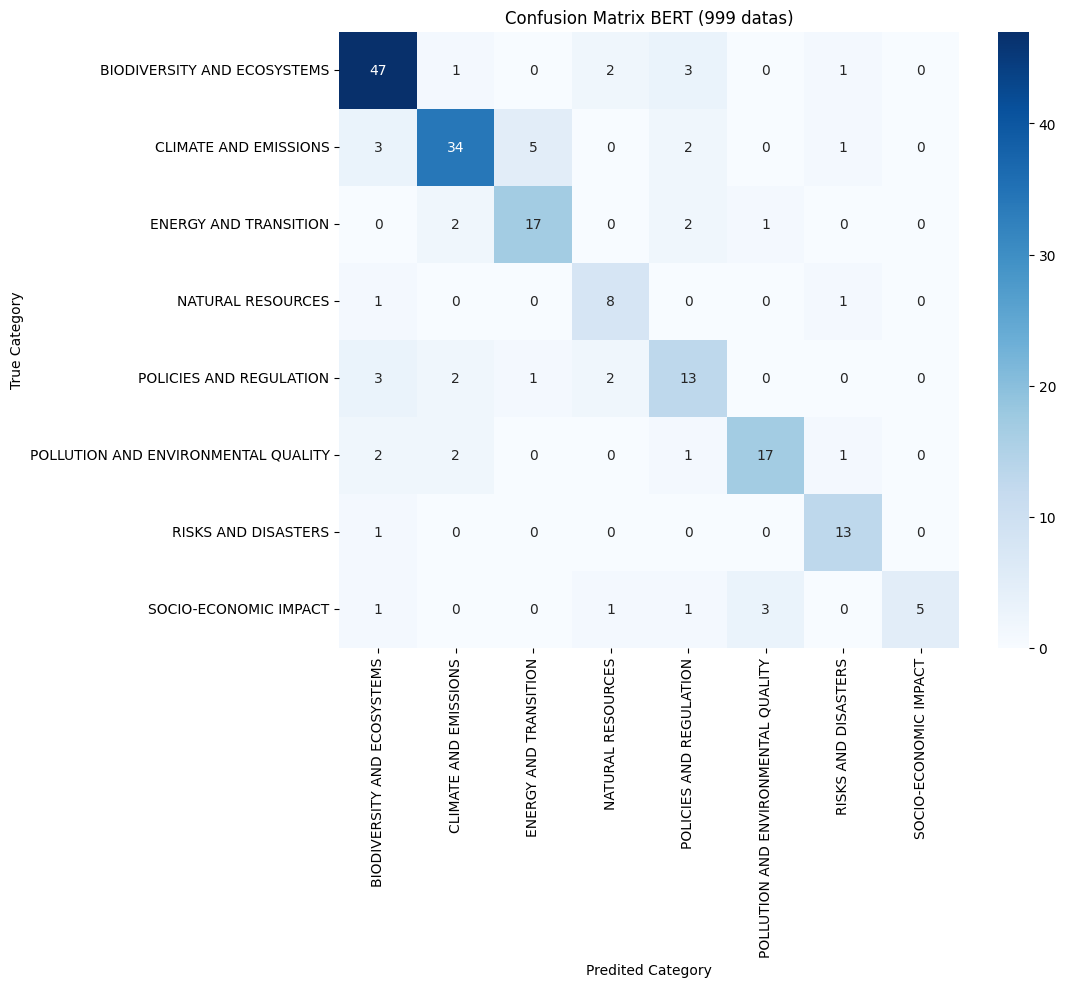

In [24]:
# Confusion Matrix and Analysis
cm = confusion_matrix(all_labels, all_preds)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predited Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix BERT (999 datas)')
plt.show() # 

In [25]:
# Analysis for the row "SOCIO-ECONOMIC IMPACT"
socio_economic_index = label_encoder.transform(['SOCIO-ECONOMIC IMPACT'])[0]
misclassified_counts = cm[socio_economic_index, :]

print("\nDocument distribution 'SOCIO-ECONOMIC IMPACT' (True) :")
for i, count in enumerate(misclassified_counts):
    if count > 0:
        print(f"  - {count} classified in : {label_encoder.inverse_transform([i])[0]}")


Document distribution 'SOCIO-ECONOMIC IMPACT' (True) :
  - 1 classified in : BIODIVERSITY AND ECOSYSTEMS
  - 1 classified in : NATURAL RESOURCES
  - 1 classified in : POLICIES AND REGULATION
  - 3 classified in : POLLUTION AND ENVIRONMENTAL QUALITY
  - 5 classified in : SOCIO-ECONOMIC IMPACT
